A notebook which contains an evaluation of the SalishSeaCast model within PugetSound. More specifically, it compares Observed data on chlorophyll concentrations collected from bottle data and compares it to various model phytoplankon outputs. This evaluation includes scatter plots visualizing the similarity of observed and model data as well as tables of evaluation statistics.

In [1]:
import sys
sys.path.append('/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
import Keegan_eval_tools as ket
from collections import OrderedDict
from matplotlib.colors import LogNorm

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [3]:
years=[2008,2009]
year=2009
modelversion='nowcast-green.201905'
PATH= '/results2/SalishSea/nowcast-green.201905/'
saveloc='/ocean/kflanaga/MEOPAR/savedData'

In [4]:
# Parameters
years = [2012, 2013]
year = 2013
modver = "nowcast-green.201905"
PATH = "/results2/SalishSea/nowcast-green.201905/"
saveloc = "/ocean/kflanaga/MEOPAR/savedData"


In [5]:
display(Markdown('''## Year: '''+ str(year)))

## Year: 2013

In [6]:
display(Markdown('''### Model output: '''+ PATH))

### Model output: /results2/SalishSea/nowcast-green.201905/

## Yearly model-data comparisons of chlorophyll between 201905 runs and Pheo observations

In [7]:
##### Saving data as Pickle files to be used in the summary file
with open(os.path.join(saveloc,f'data_Pheo_{modelversion}_{year}.pkl'),'rb') as hh:
    data_all=pickle.load(hh)

In [8]:
#Adding extra columns to assist in analysis.
data_all['log_Chl']=ket.logt(data_all['Chla_Lab'])
data_all['log_mod_diatoms']=ket.logt(data_all['mod_diatoms']*1.8)
data_all['log_mod_ciliates']=ket.logt(data_all['mod_ciliates']*1.8)
data_all['log_mod_flagellates']=ket.logt(data_all['mod_flagellates']*1.8)
data_all['mod_Chl']=((data_all['mod_diatoms']*1.8)+(data_all['mod_ciliates']*1.8)+(data_all['mod_flagellates']*1.8))
data_all['log_mod_Chl']=ket.logt((data_all['mod_diatoms']*1.8)+(data_all['mod_ciliates']*1.8)+(data_all['mod_flagellates']*1.8))

In [9]:
# Creating seperate dataframes for each season (includes only data above 15 metre depth.)
iz=(data_all.Z<15)
DJF_Pheo=data_all.loc[iz&(data_all.dtUTC>=dt.datetime(years[0],12,1))&(data_all.dtUTC<=dt.datetime(years[1],3,1)),:]
MAM_Pheo=data_all.loc[iz&(data_all.dtUTC<=dt.datetime(years[1],5,1))&(data_all.dtUTC>dt.datetime(years[1],4,1)),:]
JJA_Pheo=data_all.loc[iz&(data_all.dtUTC<=dt.datetime(years[1],9,1))&(data_all.dtUTC>dt.datetime(years[1],5,1)),:]
SON_Pheo=data_all.loc[iz&(data_all.dtUTC>dt.datetime(years[1],9,1))&(data_all.dtUTC<=dt.datetime(years[1],11,30)),:]

In [10]:
data_Pheo=data_all.loc[(data_all.dtUTC>=dt.datetime(years[0],12,1))&(data_all.dtUTC<=dt.datetime(years[1],11,30)),:]

In [11]:
# defning a dictionary that brakes the data down by individual stations
datstat_Pheo=dict()
for ind, istation in enumerate(data_Pheo.Station.unique()):
    datstat_Pheo[istation]=data_Pheo.loc[data_Pheo.Station == istation]

datreg_Pheo=dict()
for iregion in data_Pheo.Basin.unique():
    datreg_Pheo[iregion] = data_Pheo.loc[data_Pheo.Basin==iregion]  

In [12]:
### These groupings will be used to calculate statistics. The keys are labels and
### the values are corresponding dataframe views
statsubs_Pheo=OrderedDict({'z < 15 m':data_Pheo.loc[data_Pheo.Z<15],
                      '15 m < z < 22 m':data_Pheo.loc[(data_Pheo.Z>=15)&(data_Pheo.Z<22)],
                      'z >= 22 m':data_Pheo.loc[data_Pheo.Z>=22],
                      'z > 50 m':data_Pheo.loc[data_Pheo.Z>50],
                      'all':data_Pheo,
                      'z < 15 m, DJF':DJF_Pheo,
                      'z < 15 m, MAM':MAM_Pheo,
                      'z < 15 m, JJA':JJA_Pheo,
                      'z < 15 m, SON': SON_Pheo,})
for iregion in data_Pheo.Basin.unique():
    statsubs_Pheo[iregion]=datreg_Pheo[iregion]
statsubs_Pheo.keys()

odict_keys(['z < 15 m', '15 m < z < 22 m', 'z >= 22 m', 'z > 50 m', 'all', 'z < 15 m, DJF', 'z < 15 m, MAM', 'z < 15 m, JJA', 'z < 15 m, SON', 'Hood Canal Basin', 'Admiralty Inlet', 'Main Basin', 'South Basin', 'Strait of Georgia', 'Whidbey Basin', 'Strait of Juan de Fuca'])

## Map of observation locations in each basin

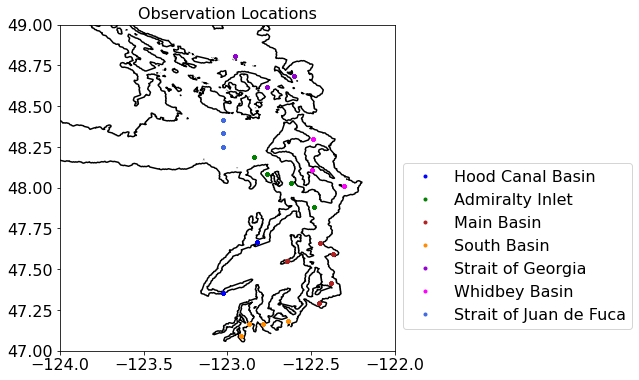

In [13]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('blue','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
for ind, iregion in enumerate(data_Pheo.Basin.unique()):
    ax.plot(datreg_Pheo[iregion]['Lon'], datreg_Pheo[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

# Chlorophyll

# Observed Chlorophyll vs Model Phytoplankton

## Model Diatoms vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets

In [14]:
#Setting variables for Chlorophyll.
obsvar='Chla_Lab'
modvar='mod_diatoms'

In [15]:
statsDict_Chl={year:dict()}
statsDict_Chl[year]['Diatoms']=OrderedDict()
for isub in statsubs_Pheo:
    statsDict_Chl[year]['Diatoms'][isub]=dict()
    var=statsDict_Chl[year]['Diatoms'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_Pheo[isub].loc[:,[obsvar]], 
                                                                     statsubs_Pheo[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl[year]['Diatoms'],level='Subset',suborder=list(statsubs_Pheo.keys()))
tbl

Text(0.5, 0, 'log10[Observed Clorophyll mg/m$^3$ (Pheo)]')

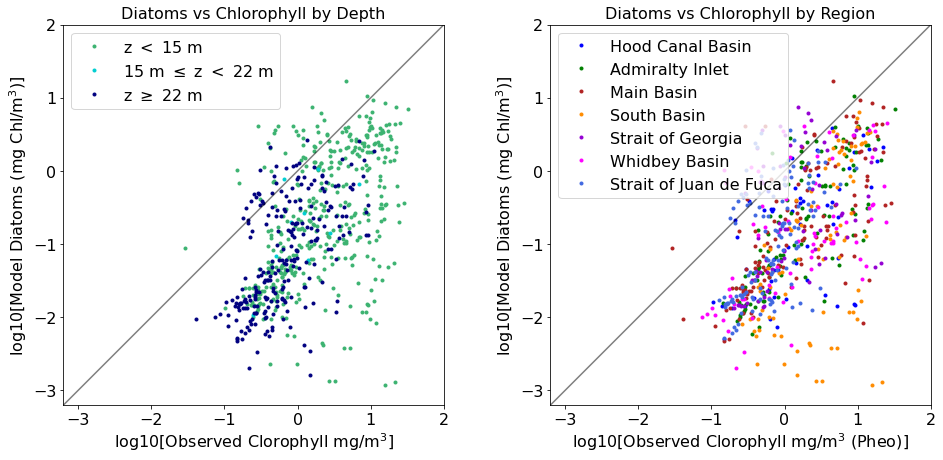

In [16]:
obsvar='log_Chl'
modvar='log_mod_diatoms'

lims=(-3.2,2)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data_Pheo,obsvar,modvar,lims)
ax[0].set_title('Diatoms vs Chlorophyll by Depth')
ax[0].set_ylabel('log10[Model Diatoms (mg Chl/m$^3$)]')
ax[0].set_xlabel('log10[Observed Clorophyll mg/m$^3$]')   

ps,l=ket.byRegion(ax[1],data_Pheo,datreg_Pheo,obsvar,modvar,lims)
ax[1].set_title('Diatoms vs Chlorophyll by Region');
ax[1].set_ylabel('log10[Model Diatoms (mg Chl/m$^3$)]')
ax[1].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (Pheo)]') 

### Model vs Observed comparisons for individual regions and stations

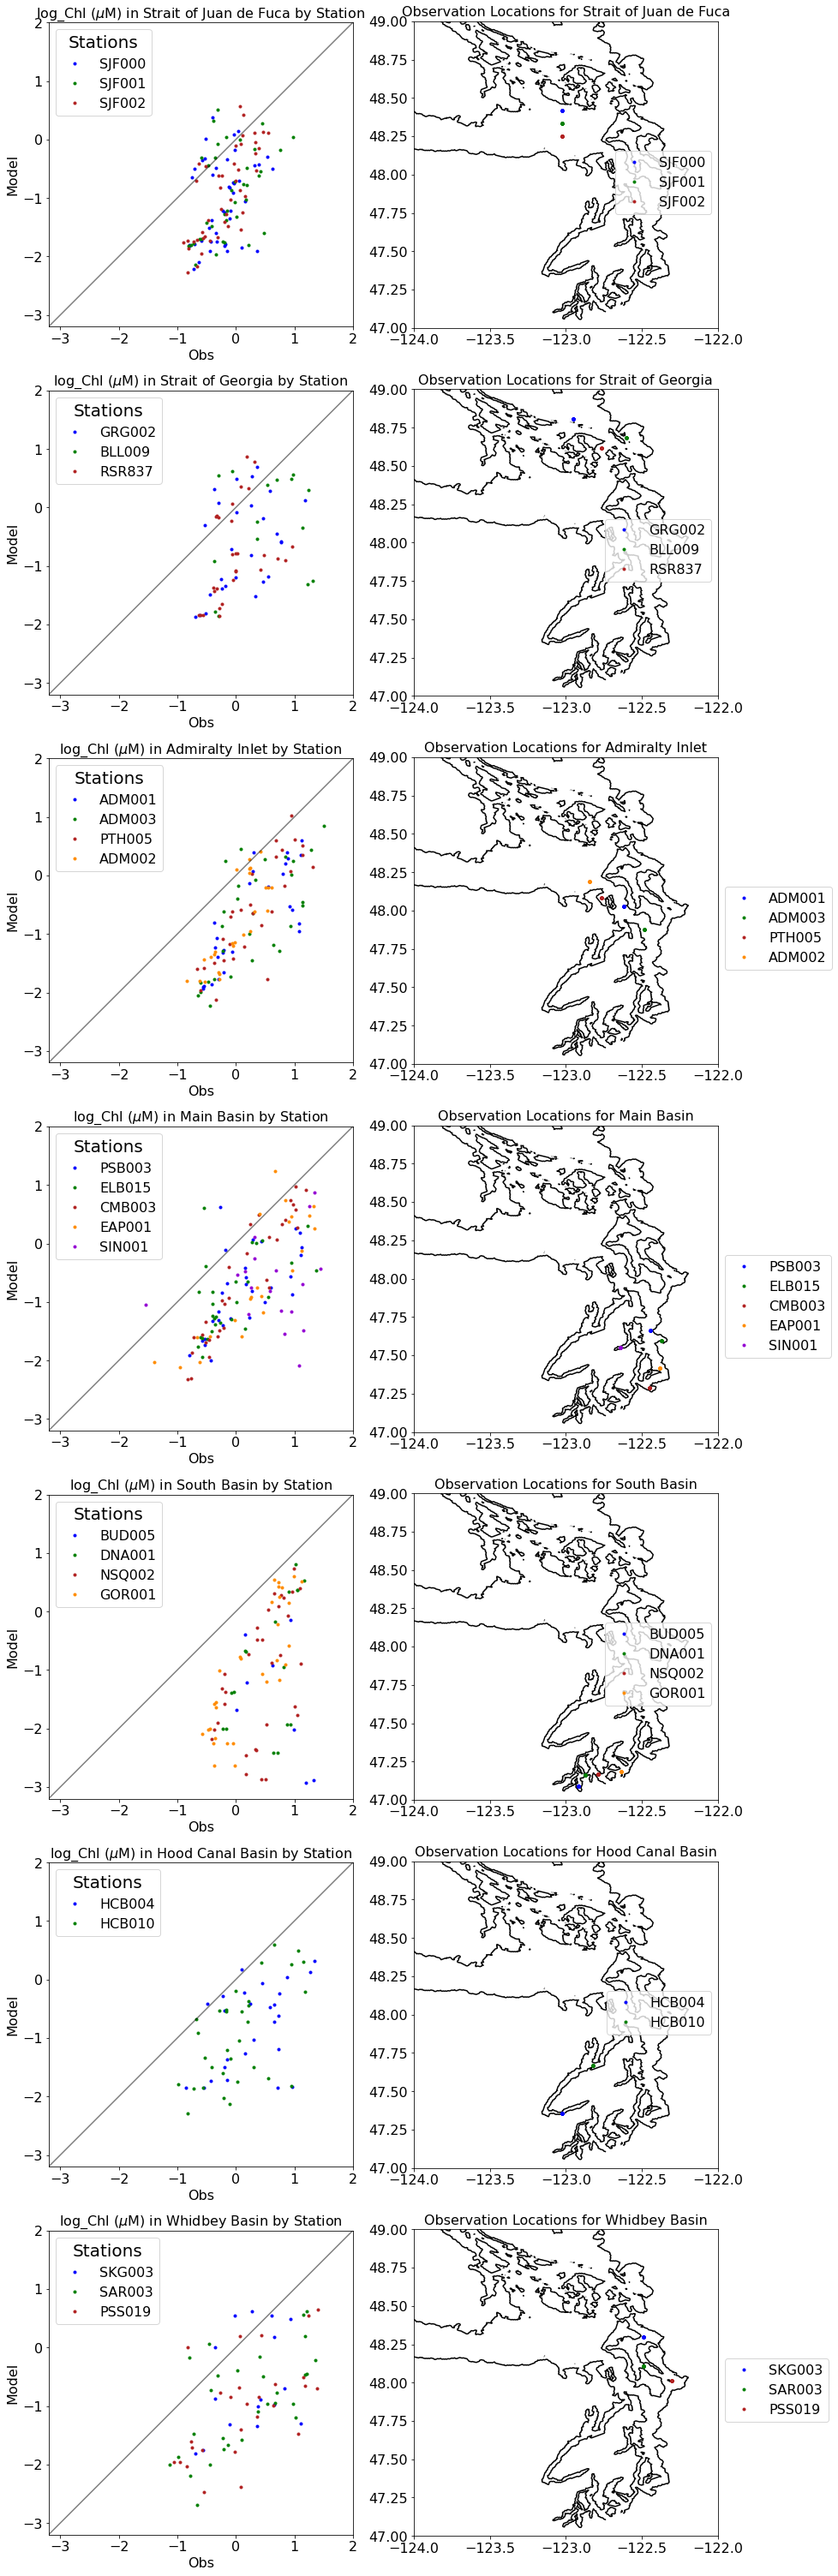

In [17]:
regions=['Strait of Juan de Fuca','Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']

ket.multi_station_graph(data_Pheo,datstat_Pheo,obsvar,modvar,regions,lims,figsize=(14,54))

### Model vs observed comparisons for multiple seasons

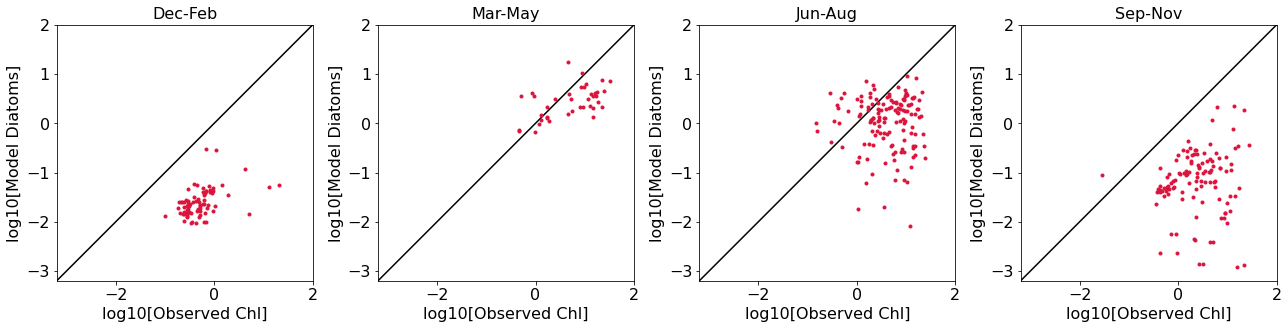

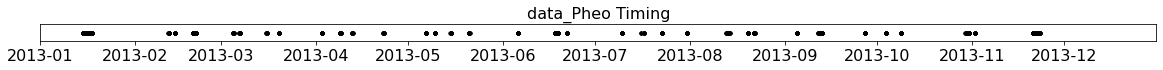

In [18]:
seasons=[DJF_Pheo,MAM_Pheo,JJA_Pheo,SON_Pheo]
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(1,4,figsize = (18,5))
ket.bySeason(ax,seasons,obsvar,modvar,lims,season_titles)
for i in range(4):
        ax[i].set_ylabel('log10[Model Diatoms]')
        ax[i].set_xlabel('log10[Observed Chl]')  
plt.tight_layout()
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_Pheo.dtUTC,np.ones(np.shape(data_Pheo.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_Pheo Timing')
ax.yaxis.set_visible(False)

## Model Ciliates vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets. 

In [19]:
obsvar='Chla_Lab'
modvar='mod_ciliates'

statsDict_Chl[year]['Ciliates']=OrderedDict()
for isub in statsubs_Pheo:
    statsDict_Chl[year]['Ciliates'][isub]=dict()
    var=statsDict_Chl[year]['Ciliates'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_Pheo[isub].loc[:,[obsvar]], 
                                                                     statsubs_Pheo[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl[year]['Ciliates'],level='Subset',suborder=list(statsubs_Pheo.keys()))
tbl

### Comparisons by depth and region

Text(0.5, 0, 'log10[Observed Clorophyll mg/m$^3$ (Pheo)]')

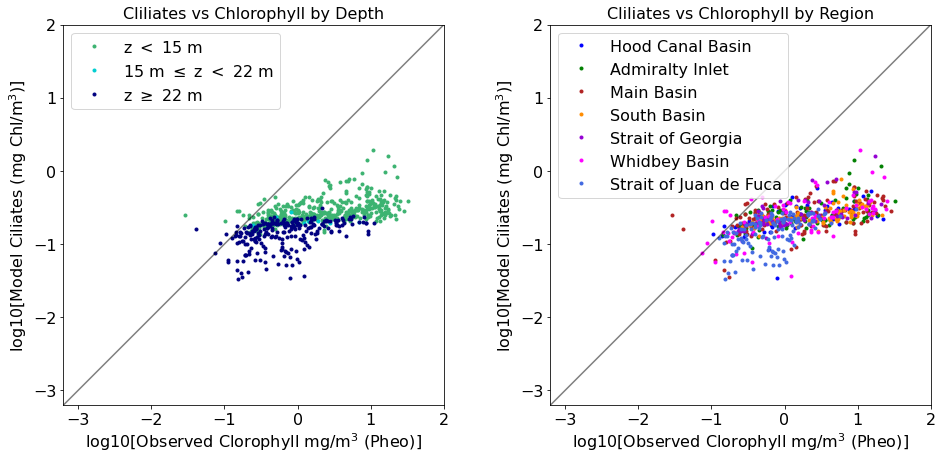

In [20]:
obsvar='log_Chl'
modvar='log_mod_ciliates'

lims=(-3.2,2)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data_Pheo,obsvar,modvar,lims)
ax[0].set_title('Cliliates vs Chlorophyll by Depth')
ax[0].set_ylabel('log10[Model Ciliates (mg Chl/m$^3$)]')
ax[0].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (Pheo)]')  

ps,l=ket.byRegion(ax[1],data_Pheo,datreg_Pheo,obsvar,modvar,lims)
ax[1].set_title('Cliliates vs Chlorophyll by Region')
ax[1].set_ylabel('log10[Model Ciliates (mg Chl/m$^3$)]')
ax[1].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (Pheo)]') 

### Model vs Observed comparisons for individual regions and stations

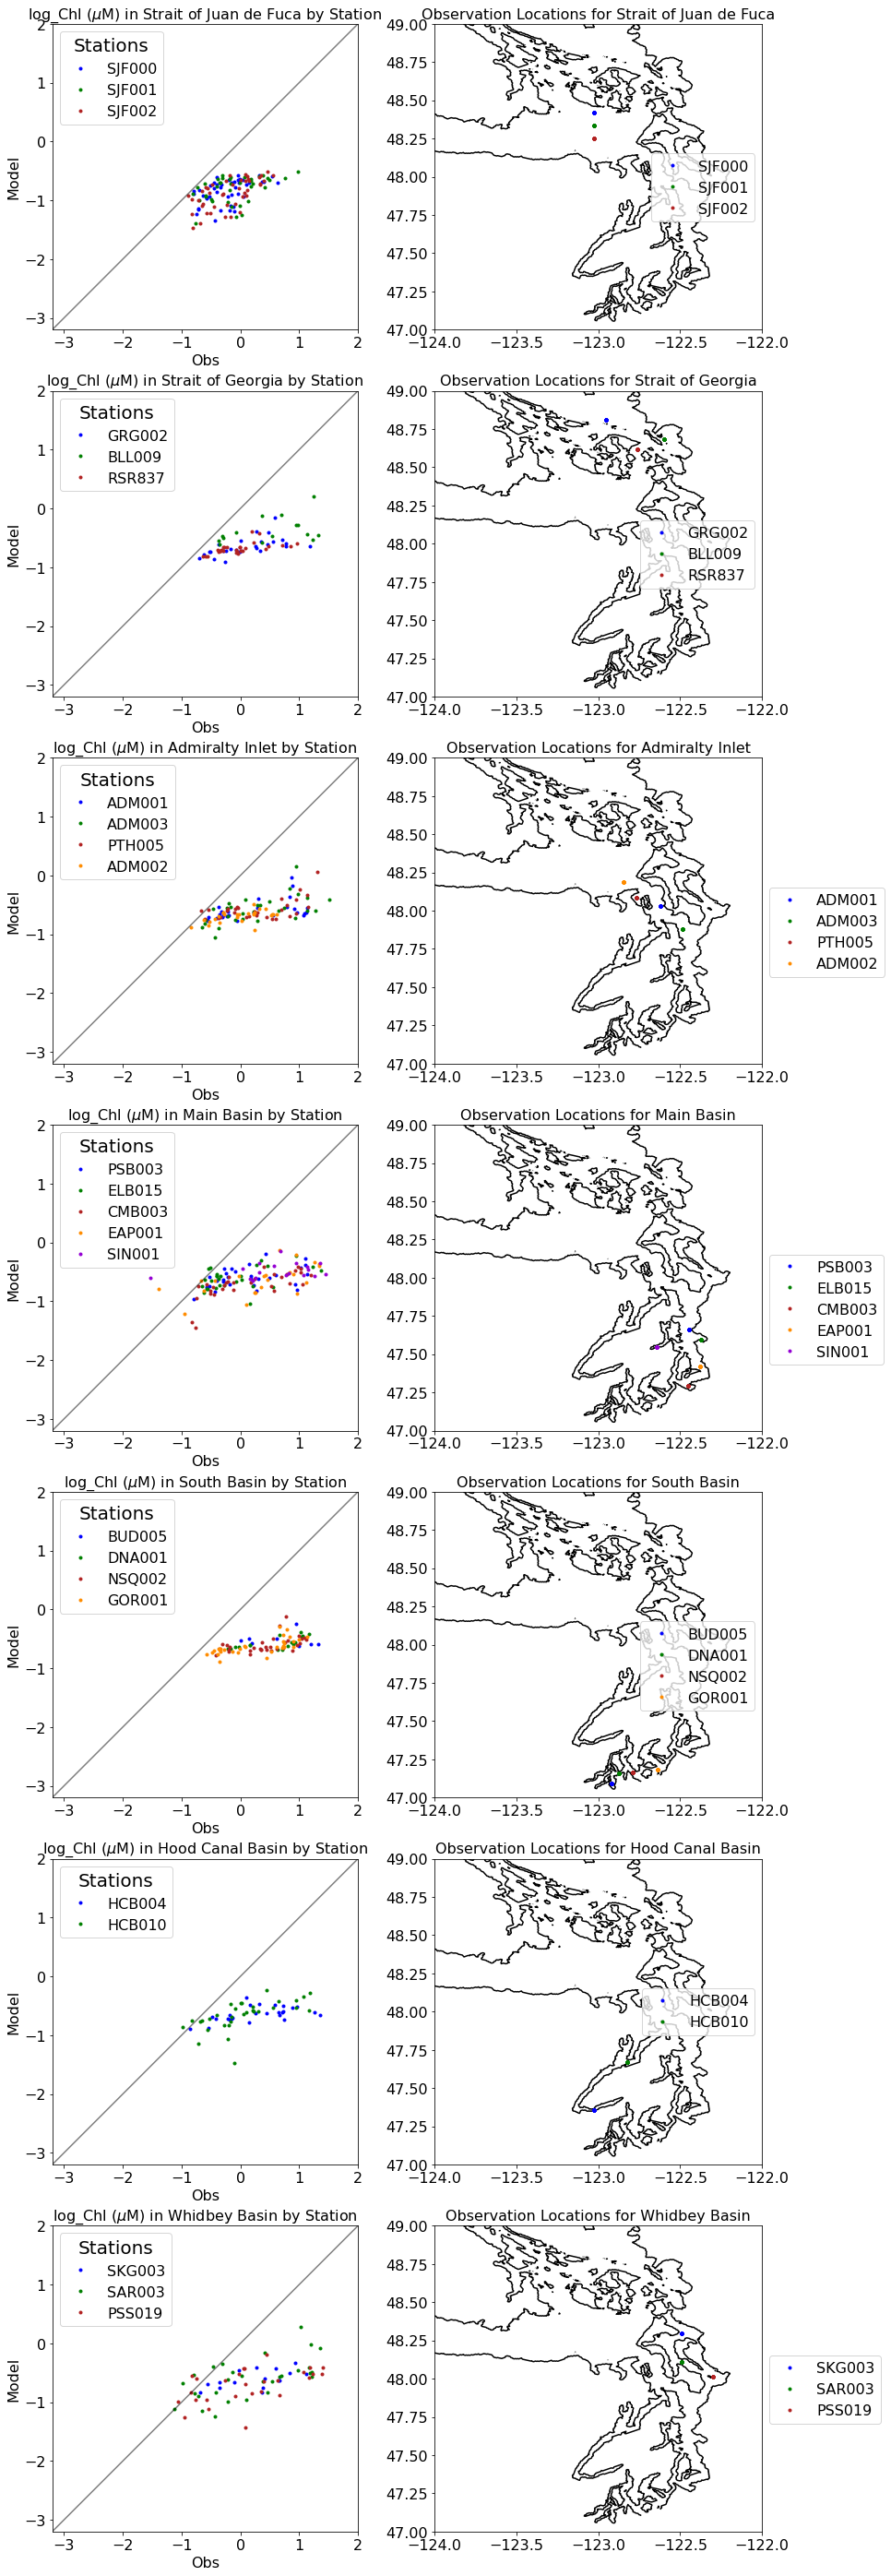

In [21]:
regions=['Strait of Juan de Fuca','Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']

ket.multi_station_graph(data_Pheo,datstat_Pheo,obsvar,modvar,regions,lims,figsize=(14,50))

## Model Ciliates vs observed Chlorophyll comparisons for multiple seasons

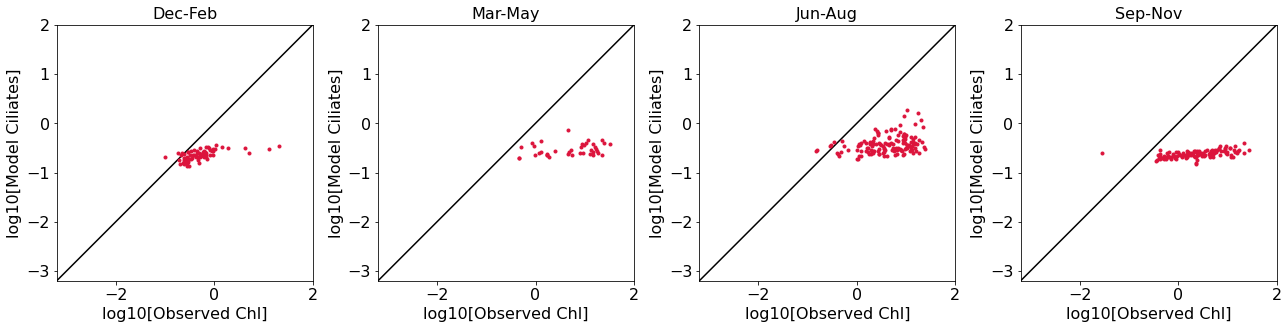

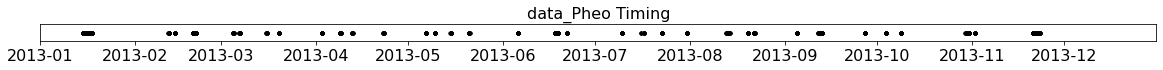

In [22]:
seasons=[DJF_Pheo,MAM_Pheo,JJA_Pheo,SON_Pheo]
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(1,4,figsize = (18,5))
ket.bySeason(ax,seasons,obsvar,modvar,lims,season_titles)
for i in range(4):
        ax[i].set_ylabel('log10[Model Ciliates]')
        ax[i].set_xlabel('log10[Observed Chl]')  
plt.tight_layout()
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_Pheo.dtUTC,np.ones(np.shape(data_Pheo.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_Pheo Timing')
ax.yaxis.set_visible(False)

## Model Flagellates vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets. 

In [23]:
obsvar='Chla_Lab'
modvar='mod_flagellates'

statsDict_Chl[year]['Flagellates']=OrderedDict()
for isub in statsubs_Pheo:
    statsDict_Chl[year]['Flagellates'][isub]=dict()
    var=statsDict_Chl[year]['Flagellates'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_Pheo[isub].loc[:,[obsvar]], 
                                                                     statsubs_Pheo[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl[year]['Flagellates'],level='Subset',suborder=list(statsubs_Pheo.keys()))
tbl

### Comparisons by depth and region

Text(0.5, 0, 'log10[Observed Clorophyll mg/m$^3$ (Pheo)]')

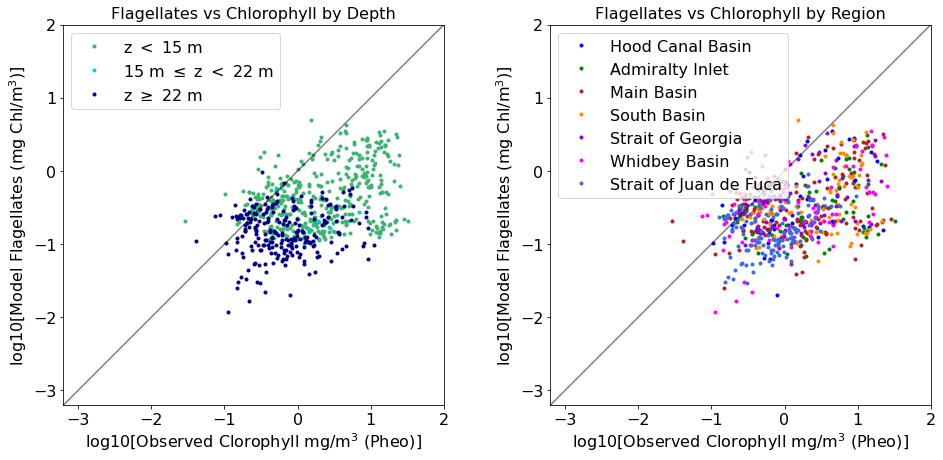

In [24]:
obsvar='log_Chl'
modvar='log_mod_flagellates'

lims=(-3.2,2)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data_Pheo,obsvar,modvar,lims)
ax[0].set_title('Flagellates vs Chlorophyll by Depth')
ax[0].set_ylabel('log10[Model Flagellates (mg Chl/m$^3$)]')
ax[0].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (Pheo)]')  

ps,l=ket.byRegion(ax[1],data_Pheo,datreg_Pheo,obsvar,modvar,lims)
ax[1].set_title('Flagellates vs Chlorophyll by Region')
ax[1].set_ylabel('log10[Model Flagellates (mg Chl/m$^3$)]')
ax[1].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (Pheo)]') 

### Model vs Observed comparisons for individual regions and stations

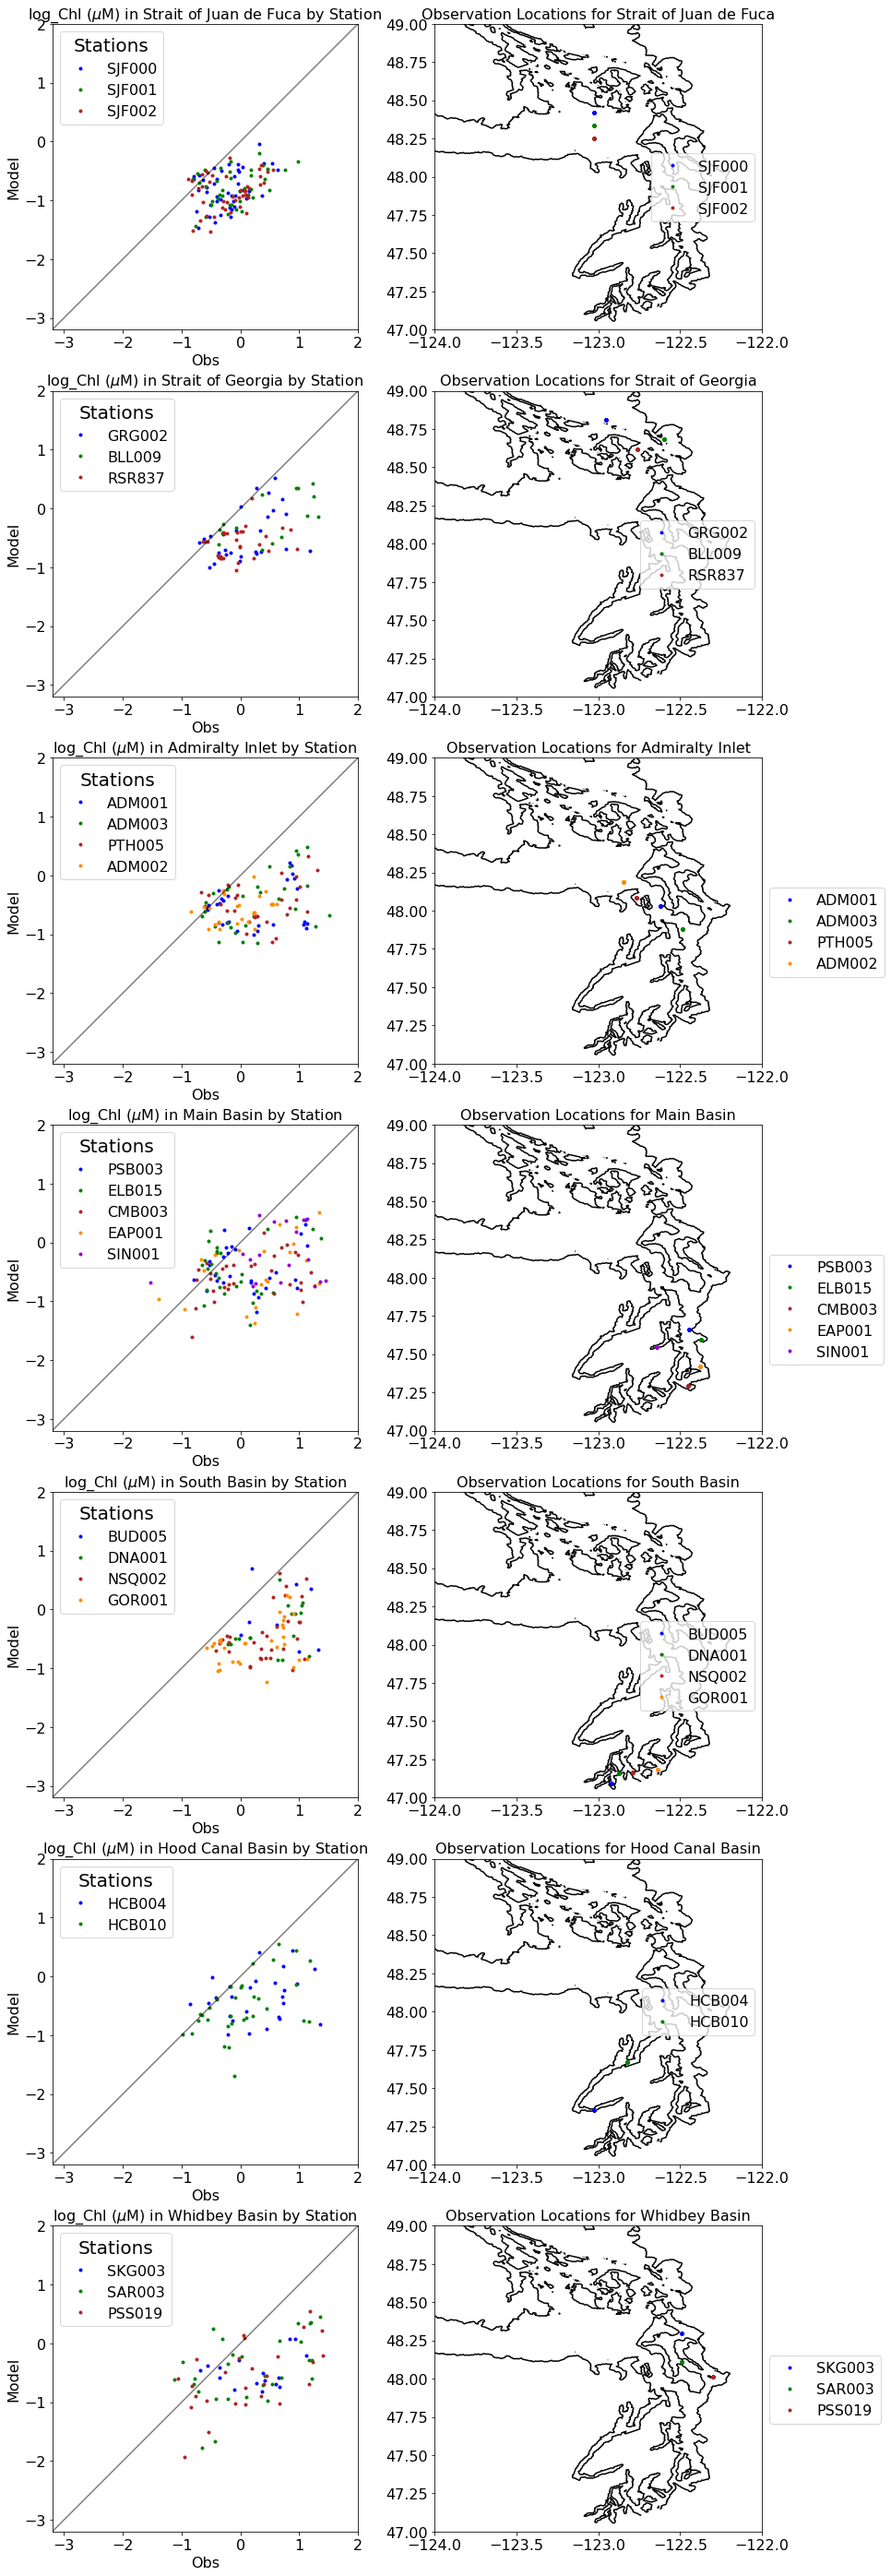

In [25]:
regions=['Strait of Juan de Fuca','Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']

ket.multi_station_graph(data_Pheo,datstat_Pheo,obsvar,modvar,regions,lims,figsize=(14,50))

### Model flagellates vs observed Chlorophyll comparisons for multiple seasons

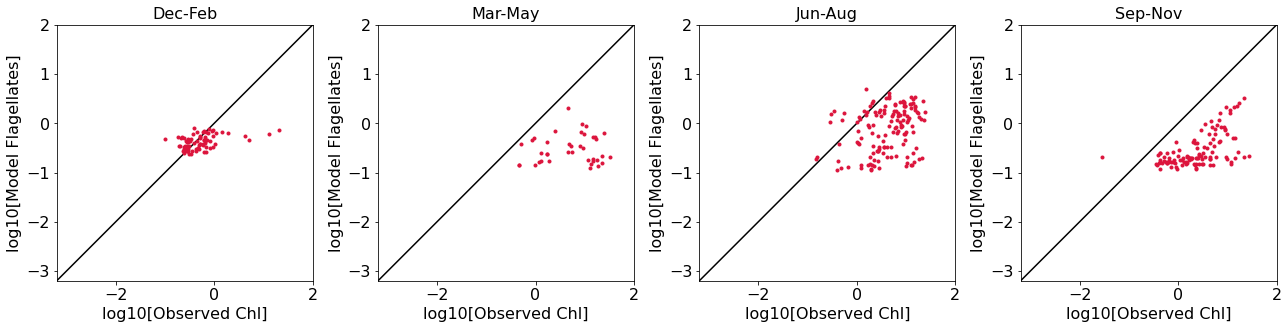

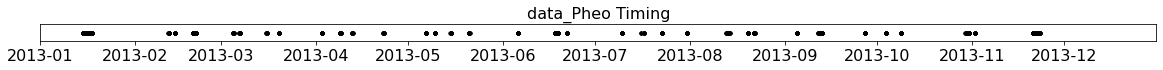

In [26]:
seasons=[DJF_Pheo,MAM_Pheo,JJA_Pheo,SON_Pheo]
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(1,4,figsize = (18,5))
ket.bySeason(ax,seasons,obsvar,modvar,lims,season_titles)
for i in range(4):
        ax[i].set_ylabel('log10[Model Flagellates]')
        ax[i].set_xlabel('log10[Observed Chl]')  
plt.tight_layout()
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_Pheo.dtUTC,np.ones(np.shape(data_Pheo.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_Pheo Timing')
ax.yaxis.set_visible(False)

## All Model Phytoplankton vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets. 

In [27]:
obsvar='Chla_Lab'
modvar='mod_Chl'

statsDict_Chl[year]['All']=OrderedDict()
for isub in statsubs_Pheo:
    statsDict_Chl[year]['All'][isub]=dict()
    var=statsDict_Chl[year]['All'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_Pheo[isub].loc[:,[obsvar]], 
                                                                     statsubs_Pheo[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl[year]['All'],level='Subset',suborder=list(statsubs_Pheo.keys()))
tbl

### Comparisons by depth and region

Text(0.5, 0, 'log10[Observed Clorophyll mg/m$^3$ (Pheo)]')

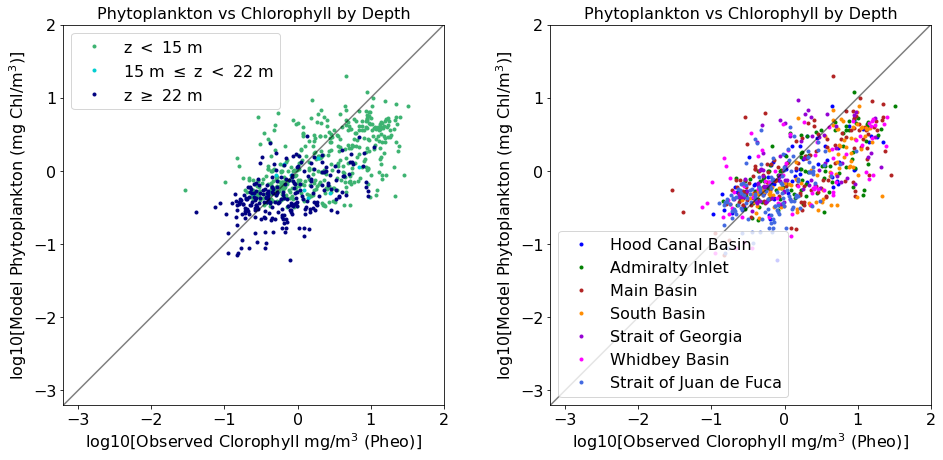

In [28]:
obsvar='log_Chl'
modvar='log_mod_Chl'

lims=(-3.2,2)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data_Pheo,obsvar,modvar,lims)
ax[0].set_title('Phytoplankton vs Chlorophyll by Depth')
ax[0].set_ylabel('log10[Model Phytoplankton (mg Chl/m$^3$)]')
ax[0].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (Pheo)]') 

ps,l=ket.byRegion(ax[1],data_Pheo,datreg_Pheo,obsvar,modvar,lims)
ax[1].set_title('Phytoplankton vs Chlorophyll by Depth')
ax[1].set_ylabel('log10[Model Phytoplankton (mg Chl/m$^3$)]')
ax[1].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (Pheo)]') 

### Model vs Observed comparisons for individual regions and stations

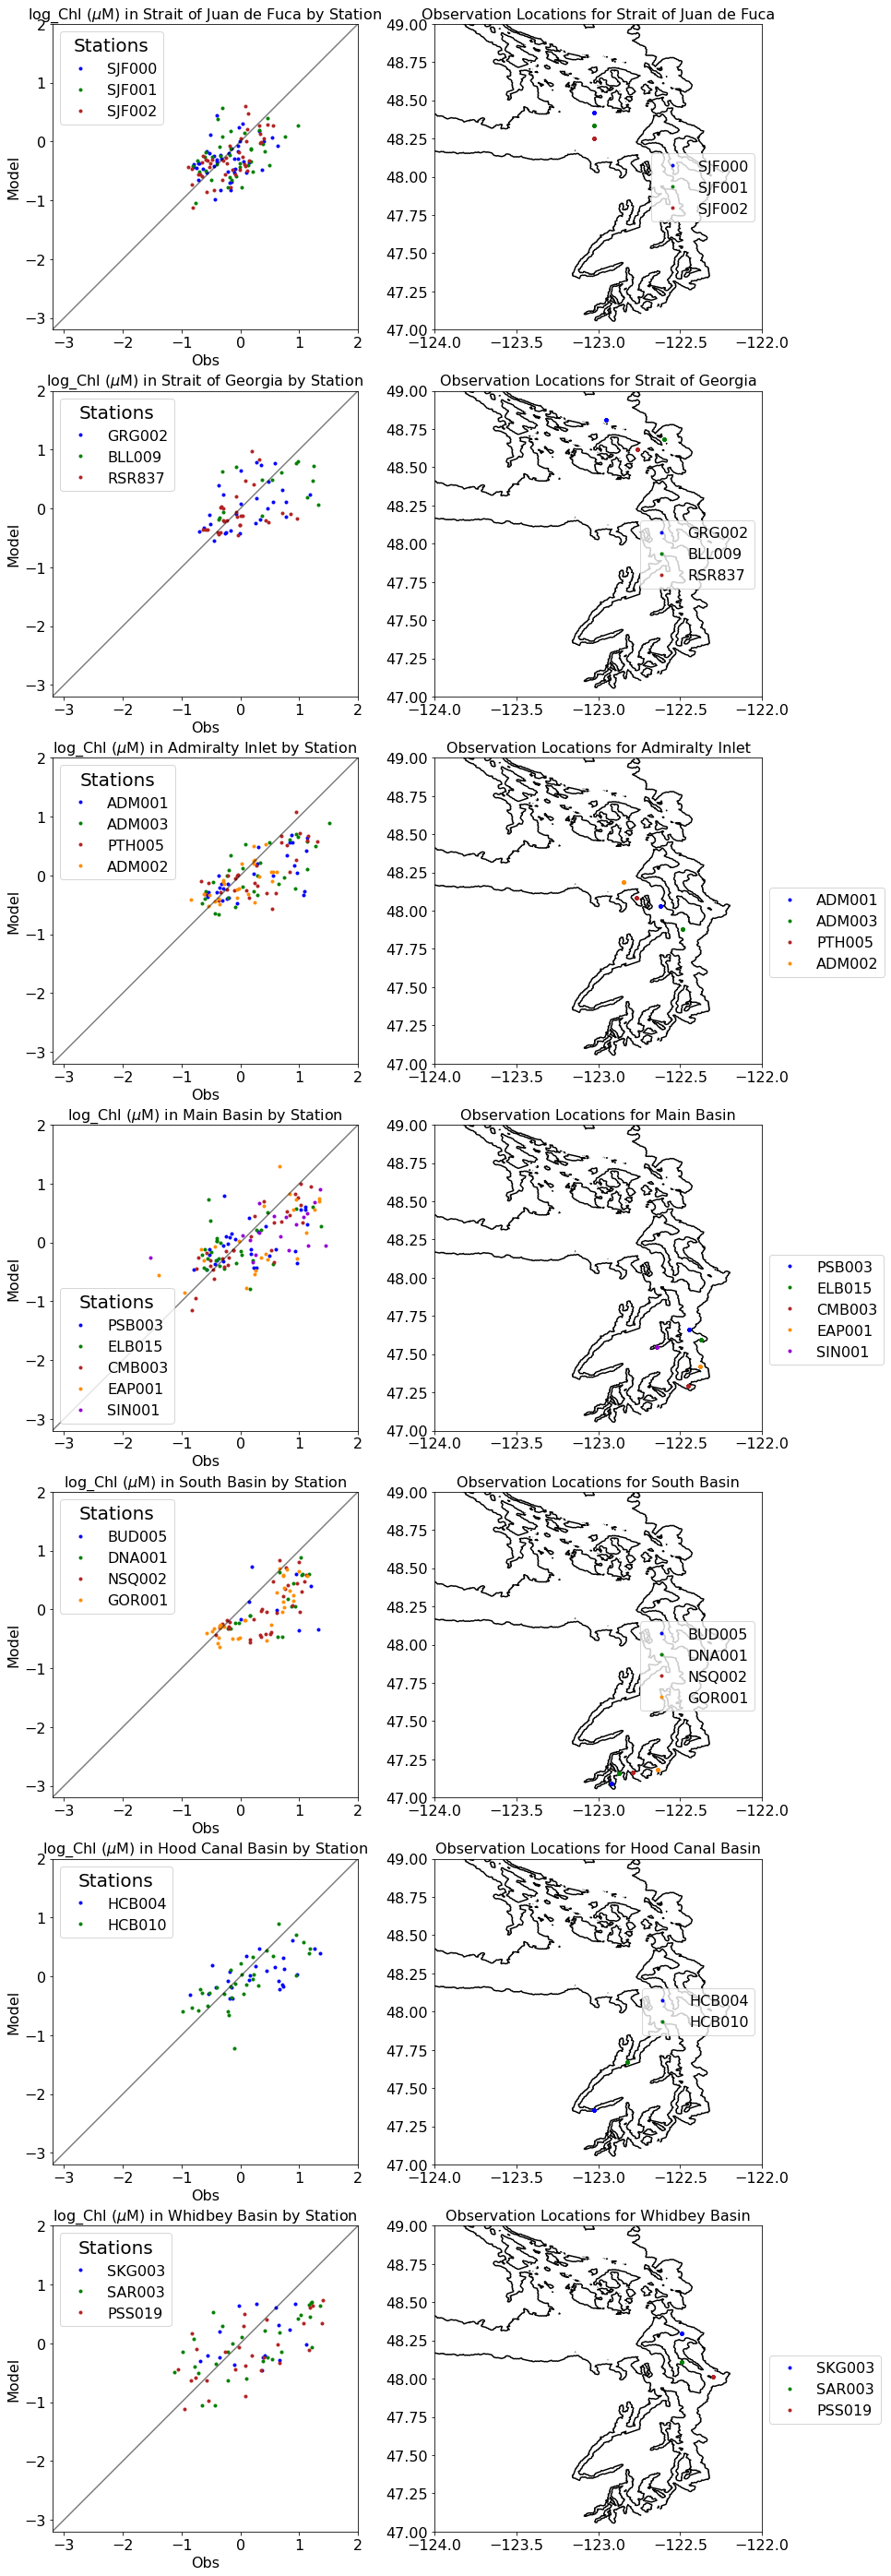

In [29]:
regions=['Strait of Juan de Fuca','Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']

ket.multi_station_graph(data_Pheo,datstat_Pheo,obsvar,modvar,regions,lims,figsize=(14,50))

## Model Chlorophyll vs observed Chlorophyll comparisons for multiple seasons

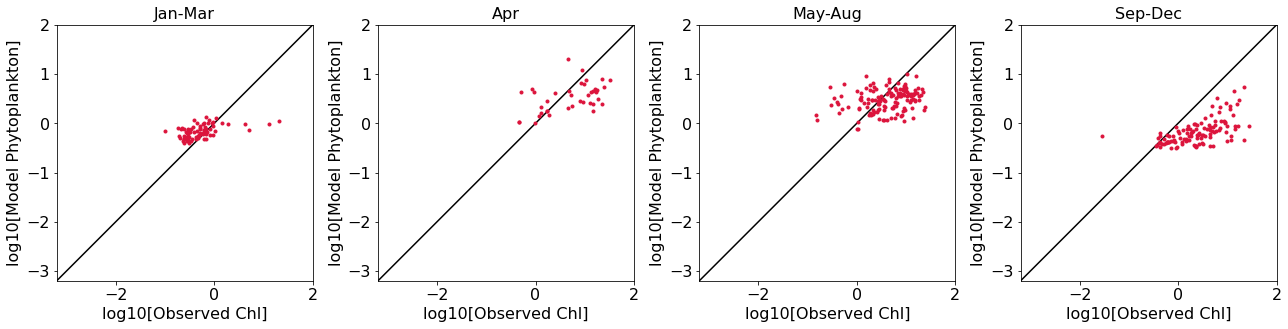

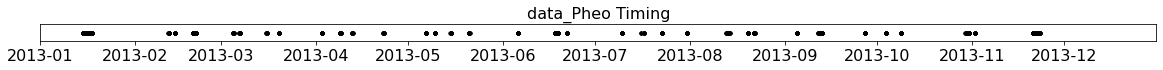

In [30]:
seasons=[DJF_Pheo,MAM_Pheo,JJA_Pheo,SON_Pheo]
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(1,4,figsize = (18,5))
ket.bySeason(ax,seasons,obsvar,modvar,lims)
for i in range(4):
        ax[i].set_ylabel('log10[Model Phytoplankton]')
        ax[i].set_xlabel('log10[Observed Chl]')  
plt.tight_layout()
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_Pheo.dtUTC,np.ones(np.shape(data_Pheo.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_Pheo Timing')
ax.yaxis.set_visible(False)

### Summary table of evaluation statistics for Temperature, Salinity, and Chlorophyll.

In [31]:
tbl,tdf=et.displayStats(statsDict_Chl[year],level='Variable',suborder=list(statsubs_Pheo.keys()))
tbl

## Error vs Salinity

Text(0, 0.5, 'Chl Error ($\\mu$M)')

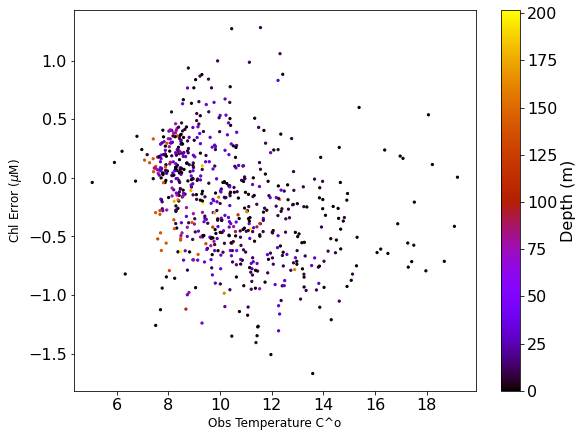

In [32]:
fig,ax=plt.subplots(1,1,figsize=(9,7))
fig.subplots_adjust(wspace=.6)
m=ax.scatter(data_Pheo['CT'],data_Pheo['log_mod_Chl']-data_Pheo['log_Chl'],c=data_Pheo['Z'],s=5,cmap='gnuplot') # what is a gnuplot and what are the other options for this?
cb=fig.colorbar(m,ax=ax,label='Depth (m)')
ax.set_xlabel('Obs Temperature C^o',fontsize=12)
ax.set_ylabel('Chl Error ($\mu$M)',fontsize=12)

# Error vs Temperature

Text(0, 0.5, 'Chl Error ($\\mu$M)')

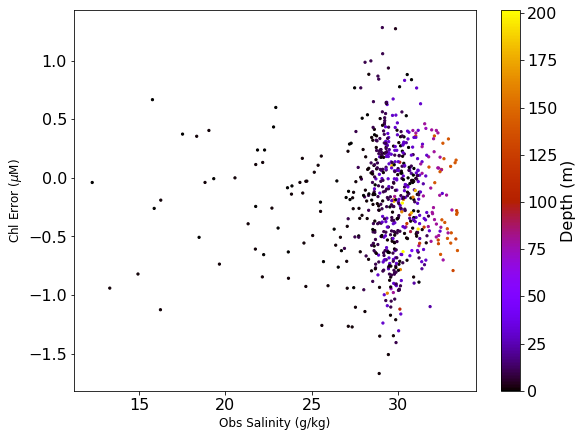

In [33]:
fig,ax=plt.subplots(1,1,figsize=(9,7))
fig.subplots_adjust(wspace=.6)
m=ax.scatter(data_Pheo['SA'],data_Pheo['log_mod_Chl']-data_Pheo['log_Chl'],c=data_Pheo['Z'],s=5,cmap='gnuplot') # what is a gnuplot and what are the other options for this?
cb=fig.colorbar(m,ax=ax,label='Depth (m)')
ax.set_xlabel('Obs Salinity (g/kg)',fontsize=12)
ax.set_ylabel('Chl Error ($\mu$M)',fontsize=12)

# CTD Environmental data.
The following sections contain model-data comparisons for temperature and salinity collected using CTD. These comparisons represent a limited subset of the total CTD data that was sampled at the same depth and time as the nutrient bottle data. An analysis of the complete CTD datasets can be found in Individual_year_CTD_evaluations. 
# Salinity

### Table containing evaluation statistics for relevant subsets

In [34]:
# Defining Variables for determining Ammonium
obsvar='SA'
modvar='mod_vosaline'
seasons=[DJF_Pheo,MAM_Pheo,JJA_Pheo,SON_Pheo]

In [35]:
statsDict_Chl[year][obsvar]=OrderedDict()
for isub in statsubs_Pheo:
    statsDict_Chl[year][obsvar][isub]=dict()
    var=statsDict_Chl[year][obsvar][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_Pheo[isub].loc[:,[obsvar]],
                                                                     statsubs_Pheo[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl[year][obsvar],level='Subset',suborder=list(statsubs_Pheo.keys()))
tbl

### Model vs Observed comparisons by depth and region

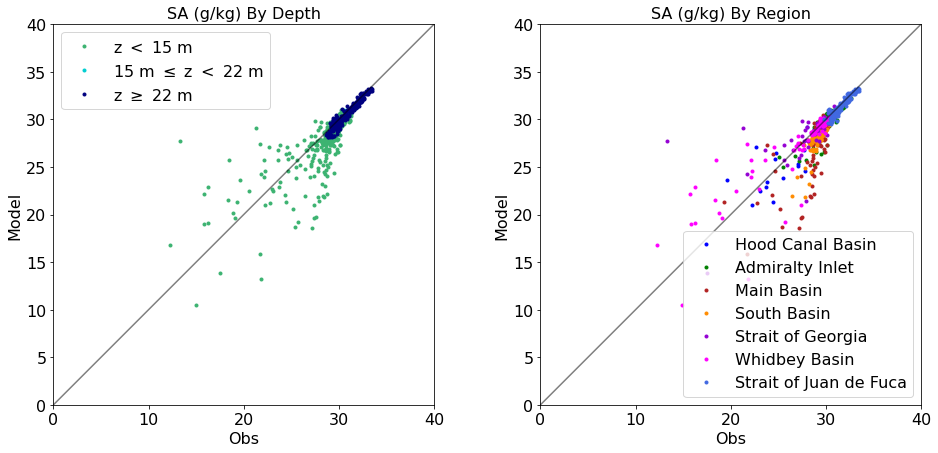

In [36]:
lims=(0,40)

fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data_Pheo,obsvar,modvar,lims)
ax[0].set_title('SA (g/kg) By Depth')

ps,l=ket.byRegion(ax[1],data_Pheo,datreg_Pheo,obsvar,modvar,lims)
ax[1].set_title('SA (g/kg) By Region');

### Model vs Observed comparisons for individual seasons

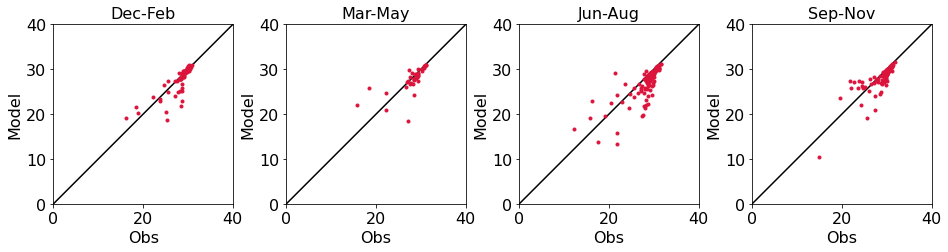

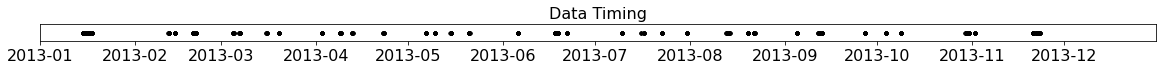

In [37]:
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(1,4,figsize = (16,3.3))
ket.bySeason(ax,seasons,obsvar,modvar,lims,season_titles)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_Pheo.dtUTC,np.ones(np.shape(data_Pheo.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Model vs Observed comparisons for individual regions and stations

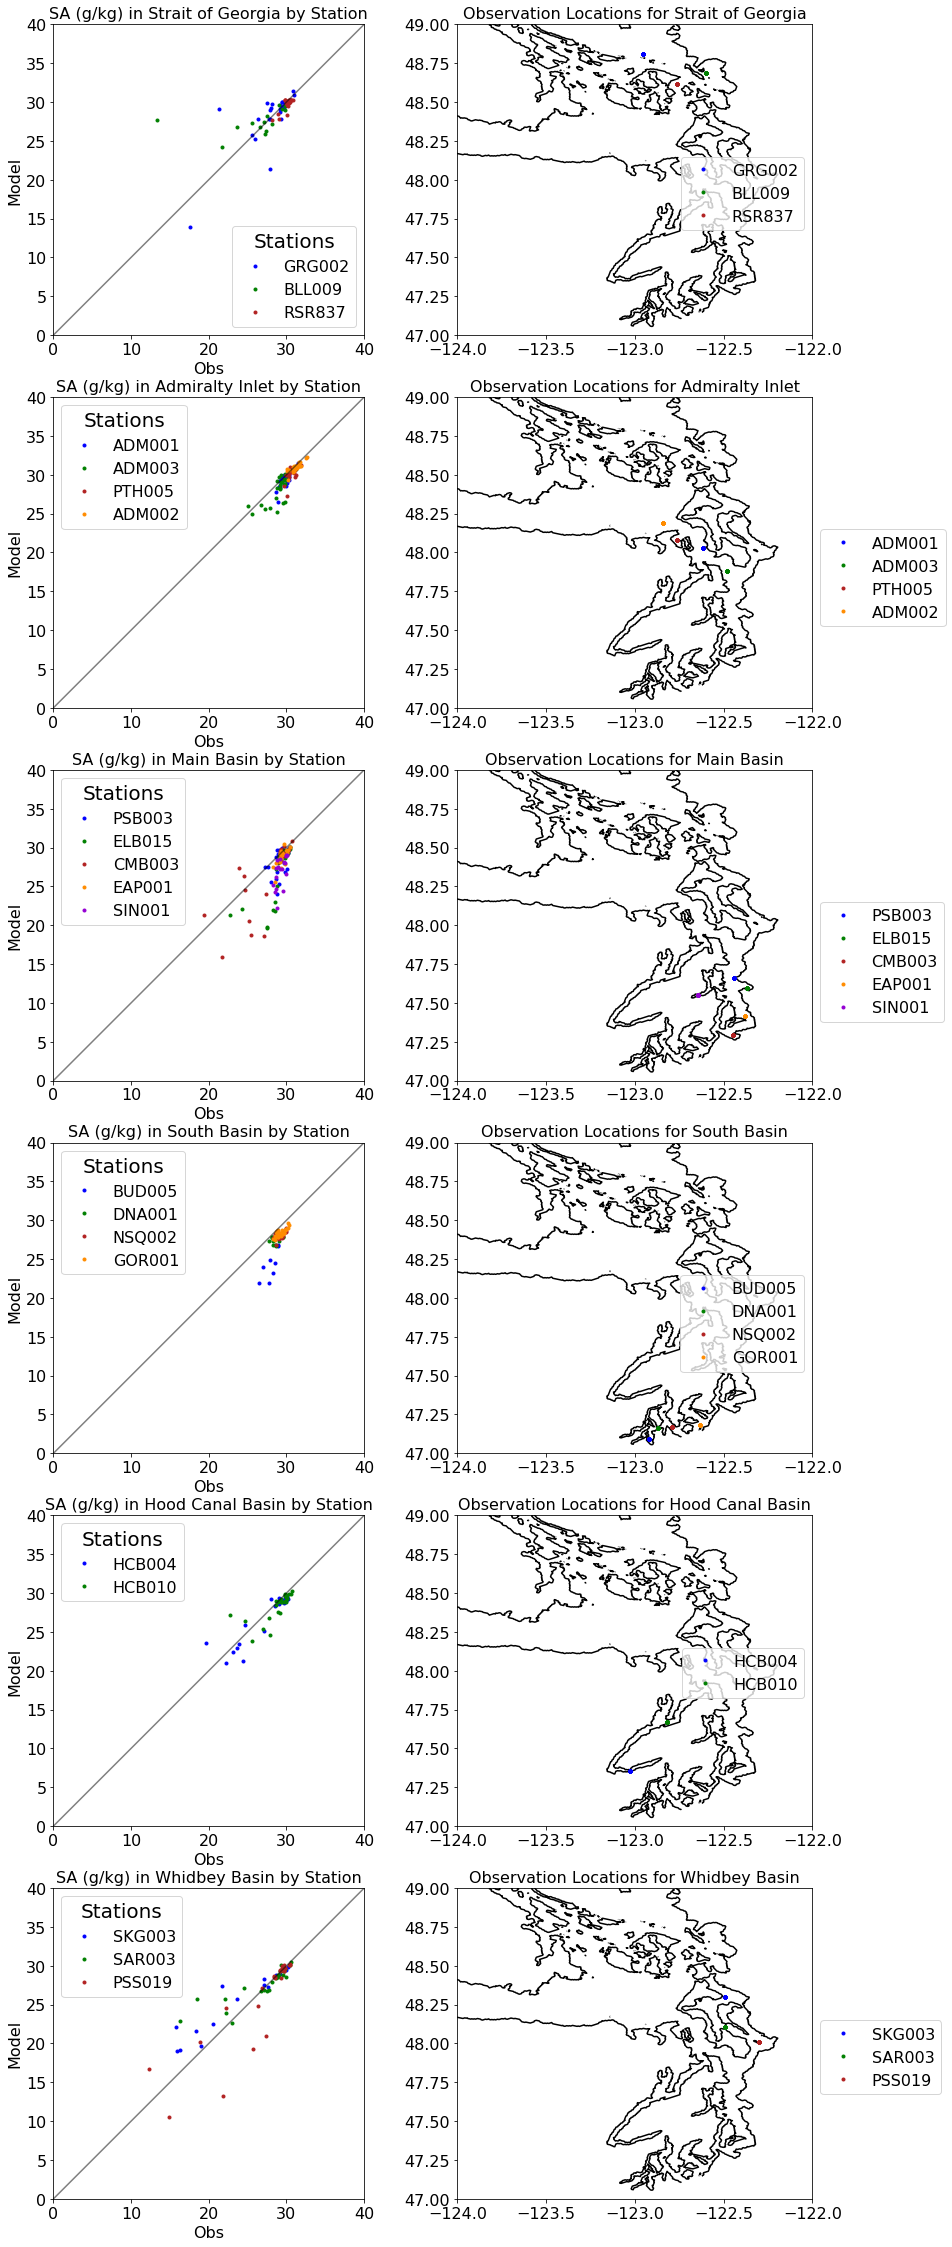

In [38]:
regions=['Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']

ket.multi_station_graph(data_Pheo,datstat_Pheo,obsvar,modvar,regions,lims,units='(g/kg)')

# Temperature

### Table containing evaluation statistics for relevant subsets

In [39]:
# Defining Variables for determining Ammonium
obsvar='CT'
modvar='mod_votemper'
seasons=[DJF_Pheo,MAM_Pheo,JJA_Pheo,SON_Pheo]

In [40]:
statsDict_Chl[year][obsvar]=OrderedDict()
for isub in statsubs_Pheo:
    statsDict_Chl[year][obsvar][isub]=dict()
    var=statsDict_Chl[year][obsvar][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_Pheo[isub].loc[:,[obsvar]],
                                                                     statsubs_Pheo[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl[year][obsvar],level='Subset',suborder=list(statsubs_Pheo.keys()))
tbl

### Model vs Observed comparisons by depth and region

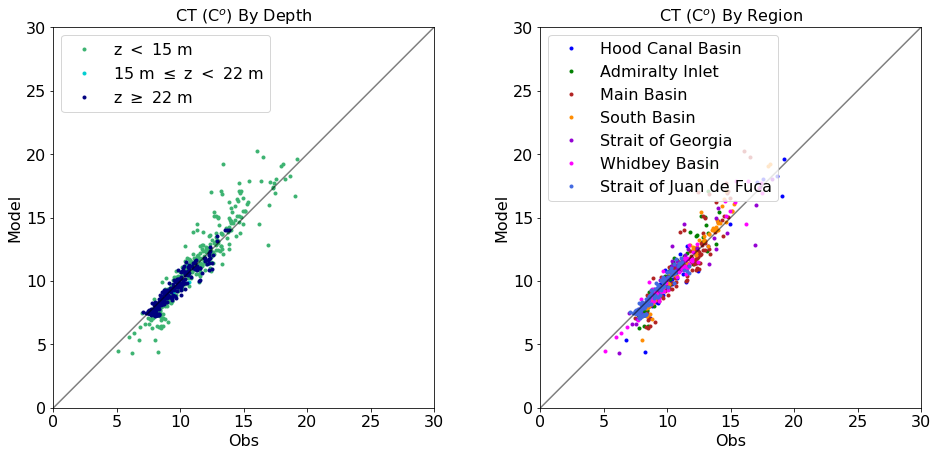

In [41]:
lims=(0,30)

fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data_Pheo,obsvar,modvar,lims)
ax[0].set_title('CT (C$^o$) By Depth')

ps,l=ket.byRegion(ax[1],data_Pheo,datreg_Pheo,obsvar,modvar,lims)
ax[1].set_title('CT (C$^o$) By Region');

### Model vs Observed comparisons for individual seasons

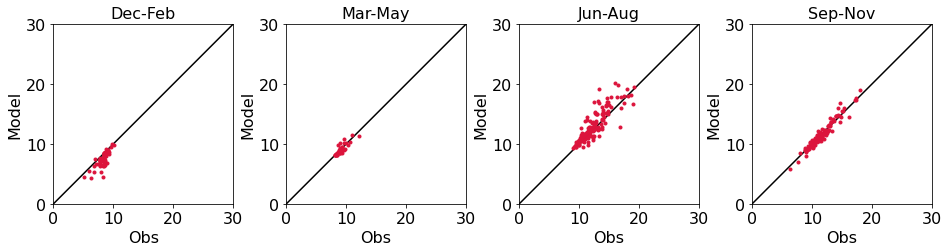

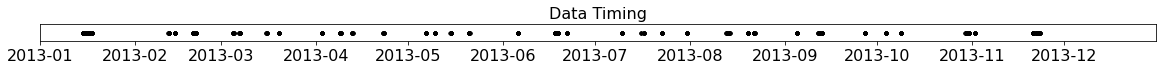

In [42]:
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(1,4,figsize = (16,3.3))
ket.bySeason(ax,seasons,obsvar,modvar,lims,season_titles)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_Pheo.dtUTC,np.ones(np.shape(data_Pheo.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Model vs Observed comparisons for individual regions and stations

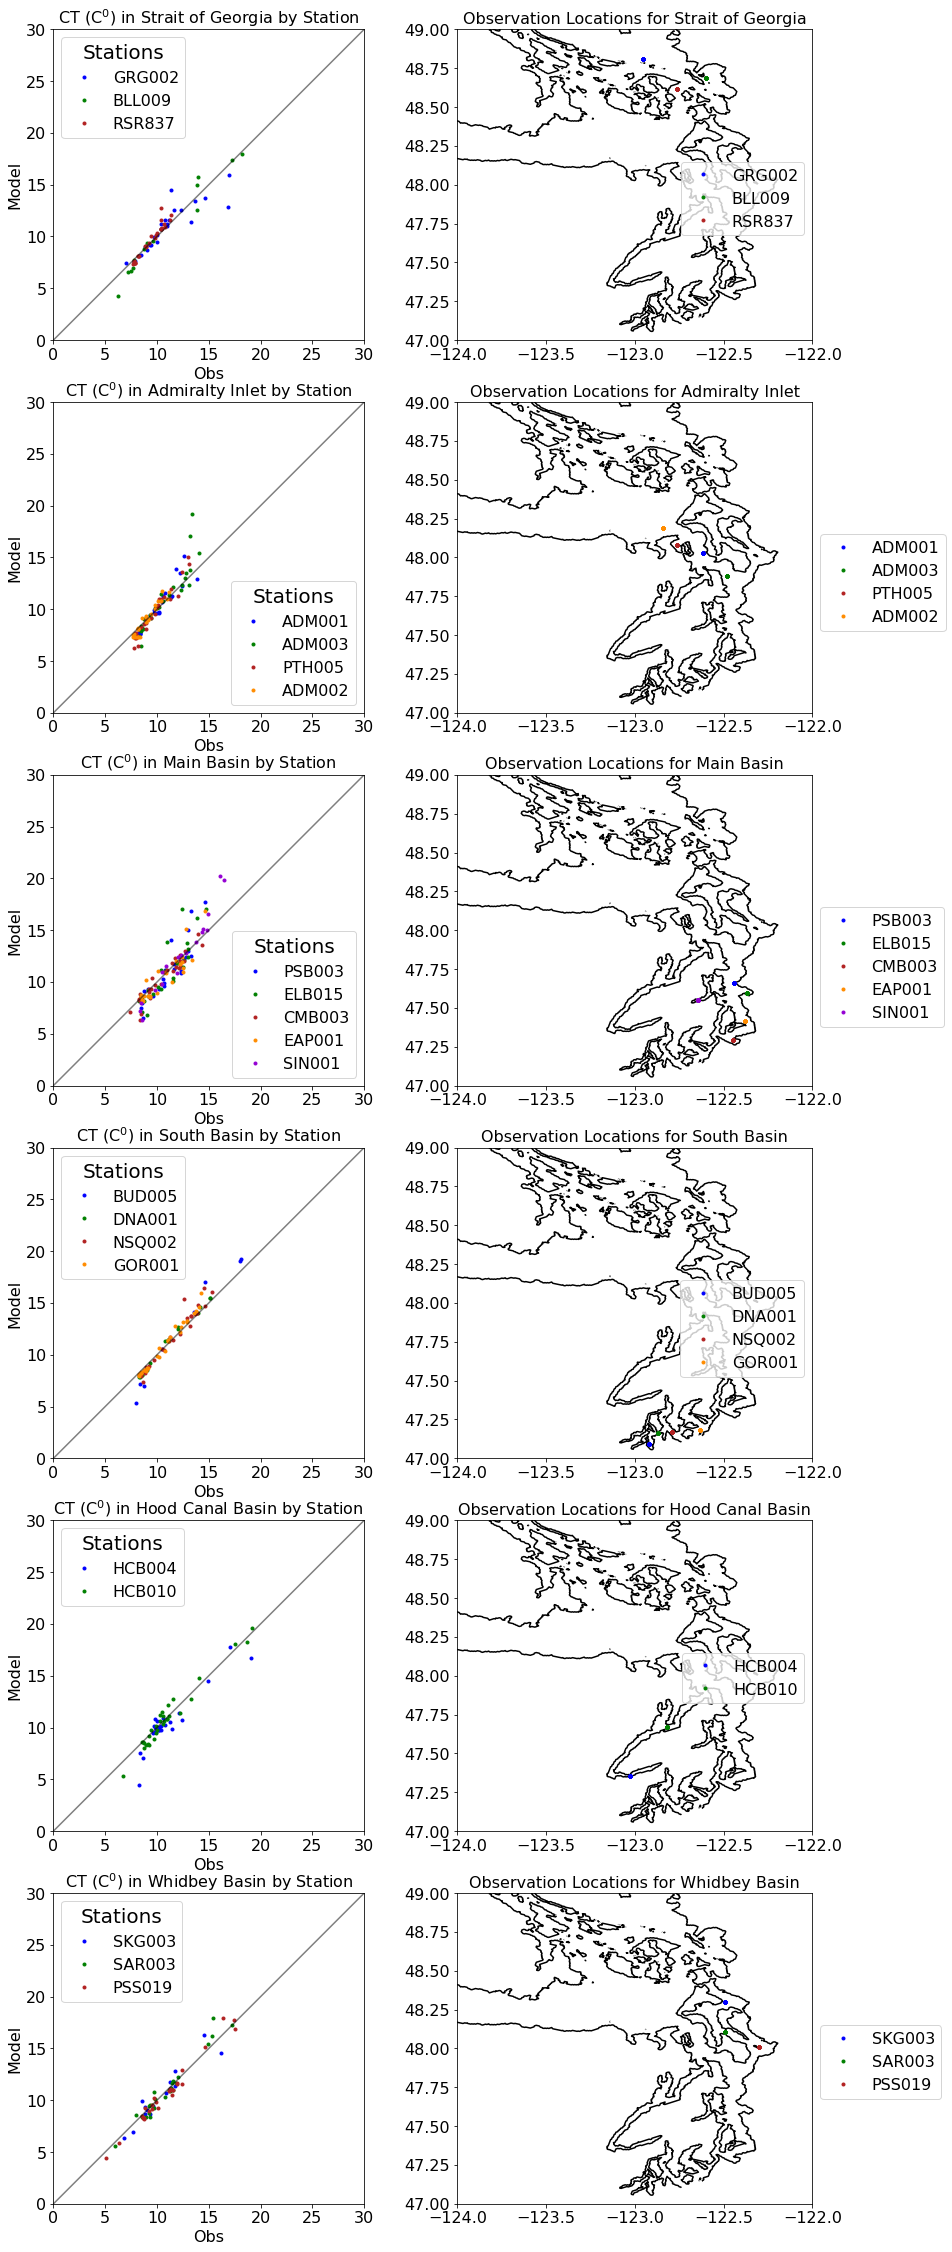

In [43]:
regions=['Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']

ket.multi_station_graph(data_Pheo,datstat_Pheo,obsvar,modvar,regions,lims,units='(C$^0$)')